# Seminario Avanzado de Aprendizaje Automático
# _Inteligencia Artificial Explicable_
# Práctica 2

### Miguel A. Gutiérrez Naranjo
### _Versión del 16 de mayo de 2024_




Los documentos básicos para esta práctica han sido el código del libro **Explainable AI for Practitioners. Designing and Implmenting Explainable ML Solutions** de _M. Munn y D. Pitman_, O'Reilly, 2022 y del libro **Applied Machine Learning Explainability Techniques** de
_Aditya Bhattacharya_, Packt, 2022

En primer lugar cargamos las librerías que vamos a utilizar. En particular, importamos 'fetch_california_housing' de scikit learn para utilizar el dataset _California Housing Dataset_. Más información en  https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.

Cargamos las librerías que vamos a utilizar

In [1]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

from sklearn.datasets import fetch_openml
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Cargamos el dataset directamente de Scikit-learn

In [2]:
housing = fetch_california_housing()
housing_data = housing.data
housing_target = housing.target
housing_feature_names = housing.feature_names

Si cargar el 'bunch' de scikit learn da problemas, puedes cargarlo desde tu Google Drive, descomenta y ejecuta las siguientes líneas para cargarlo desde tu Googe Drive. No olvides cambiar el directorio de trabajo por el tuyo.

In [ ]:
from google.colab import drive
drive.mount ('/content/drive')
%cd 'drive/MyDrive/SAAA_2024'
housing_data = np.load('housing_data.npy')
housing_target = np.load('housing_target.npy')
housing_feature_names = ['MedInc','HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']


Mounted at /content/drive
/content/drive/MyDrive/SAAA_2024


El _California Housing Dataset_ tiene 20640 instancias. Cada instancia representa un bloque de vecinos (entre 600 y 3000 vecinos) y contiene ocho atributos, como por ejemplo, la media de número de dormitorios por piso o los ingresos medios de los residentes en el bloque. La etiqueta de clasificación 'MedianHouseVal' es el precio medio de la vivienda del bloque expresado en cientos de miles de dólares (datos de 1990).

In [3]:
housing_data.shape

(20640, 8)

In [4]:
housing_target.shape

(20640,)

En primer lugar, vamos a considerar el problema de regresión para intentar predecir el precio de una vivienda a partir de los atributos de dataset. Dividimos el conjunto de entrenamiento en _train_, _test_ y _valid_.

In [5]:
X_train_full_orig, X_test_orig, y_train_full, y_test = train_test_split(housing_data, housing_target)
X_train_orig, X_valid_orig, y_train, y_valid = train_test_split(X_train_full_orig, y_train_full)

Escalamos los datos. En este caso utilizamos _StandardScaler_, pero podíamos haber elegido otros tipos de escalado. Puedes ver las diferencias entre los distintos tipos de escalado [aquí](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#plot-all-scaling-standard-scaler-section)

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_orig)
X_test = scaler.transform(X_test_orig)
X_valid = scaler.transform(X_valid_orig)

Creamos un _dataframe_ de _pandas_ y le concatenamos los valores de salida como una columna más 'MedianHouseVal'. Vemos, además, los primeros datos del conjunto que vamos a usar para entrenar.

In [7]:
df = pd.concat((pd.DataFrame(X_train, columns=housing_feature_names),
                pd.DataFrame({'MedianHouseVal': y_train})), axis=1)

df.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0 -0.935663  1.219868  0.386672   0.352083   -0.893407  0.017592 -0.333221   
1 -0.362630  1.775367 -0.021633   0.446605   -0.700486 -0.086527  0.611554   
2 -1.348439  1.140512 -0.711100   0.002653   -0.008033  0.072043 -0.754160   
3 -0.126977  1.061155 -0.733357  -0.279880   -0.180285 -0.063173  0.803315   
4  0.511353  0.585013  0.189243  -0.275600   -0.196649 -0.020666 -0.843025   

   Longitude  MedianHouseVal  
0  -0.518158           0.738  
1  -1.219227           4.000  
2   0.658637           1.072  
3  -1.179166           2.392  
4   0.733751           2.257

Para la regresión, usamos keras para crear un MLP simple con una única capa oculta. Usamos ReLU en esa capa oculta. La capa de salida tiene una única neurona y como función de activación usamos la función identidad. Vamos a usar el error cuadrático medio (MSE) como función de error y el descenso estocástico por gradiente como método de optimización. Además monitorizaremos el índice $R^2$. Más información sobre $R^2$ en https://es.wikipedia.org/wiki/Coeficiente_de_determinaci%C3%B3n

In [8]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=[tf.keras.metrics.R2Score()])

Entrenamos el modelo. Por defecto el tamaño del batch es 32.

In [9]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/100
363/363 [==============================] - 2s 3ms/step - loss: 1.5515 - r2_score: -0.1594 - val_loss: 0.6882 - val_r2_score: 0.4826
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5200 - r2_score: 0.6114 - val_loss: 0.4898 - val_r2_score: 0.6318
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4465 - r2_score: 0.6663 - val_loss: 0.4537 - val_r2_score: 0.6589
Epoch 4/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4296 - r2_score: 0.6790 - val_loss: 0.4222 - val_r2_score: 0.6826
Epoch 5/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4173 - r2_score: 0.6882 - val_loss: 0.4192 - val_r2_score: 0.6848
Epoch 6/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4117 - r2_score: 0.6924 - val_loss: 0.4078 - val_r2_score: 0.6934
Epoch 7/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4034 - r2_score: 0.6986 - val_loss: 0.4036 - val_r2_score: 0.696

Veamos cómo ha ido la evolución de la función de error (MSE) durante el entrenamiento

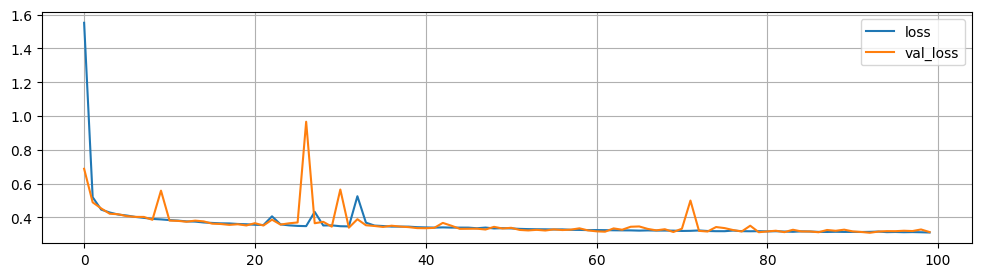

In [10]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(12,3))
plt.grid(True)
plt.show()

Vemos la evolución del índice $R^2$

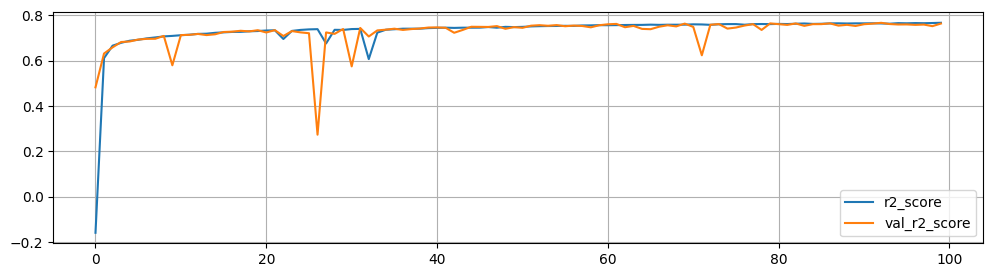

In [11]:
pd.DataFrame(history.history)[['r2_score', 'val_r2_score']].plot(figsize=(12,3))
plt.grid(True)
plt.show()

Calculamos el error cuadrático medio y el índice $R^2$ sobre el conjunto de test

In [12]:
metricas = model.metrics_names
eval_test = model.evaluate(X_test, y_test,verbose=0)
for m,v in zip(metricas,eval_test):
  print(m,':',v)

loss : 0.3058120608329773
r2_score : 0.7678536772727966


# Importancia de los atributos mediante permutación <br> _(Permutation feature Importance)_

A continuación vamos a reordenar de manera aleatoria los valores del primer atributo 'MedInc" en el conjunto de test y calculamos los valores de MSE y $R^2$ sobre el conjunto permutado. Si la diferencia con los valores obtenidos sobre el conjunto de test original es _pequeña_ consideraremos que ese atributo es poco importante. Si la diferencia es _grande_ consderaremos que los valores de ese atributo tienen mucha importancia para la predicción. Recuerda que la diferencia es _pequeña_ o _grande_ en valores relativos, esto es, en comparación con las diferencias obtenidas al permutar otros atributos. <br><br> Vemos los primeros valores antes de hacer la modificación.

In [13]:
df_test = pd.concat((pd.DataFrame(X_test, columns=housing_feature_names),
                pd.DataFrame({'MedianHouseVal': y_test})), axis=1)

df_test.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0 -0.388696  0.902441 -0.151816  -0.119571    0.019527 -0.042616  0.489949   
1 -0.183339  0.426299  0.194455  -0.065293    0.102208 -0.048750  1.341182   
2  0.616094 -1.875052  0.496450   0.095321    1.936689  0.008930  0.999754   
3 -1.028931  1.854724 -0.717412  -0.461028   -0.007172  0.031923 -0.758837   
4 -0.903358 -0.446627 -0.135818  -0.035192   -0.999342 -0.015347  1.813570   

   Longitude  MedianHouseVal  
0  -1.048968           1.923  
1  -0.943807           1.098  
2  -0.938800           1.948  
3   0.628591           1.200  
4  -1.314372           0.530

Reordenamos aleatoriamente los valores de 'MedInc' y vemos los primeros valores. Para ello usamos la función 'shuffle_columna' que toma como dato de entrada un array de numpy y el índice de la columna cuyos valores quiero permutar aleatoriamente.

In [14]:
def shuffle_columna(A,i):
  B = np.copy(A)
  # perm es una permutación de array([0,...,n(f-1)]) donde nf es el número de filas de la matriz
  perm = np.random.permutation(B.shape[0])
  # Sustituimos en B los valores de la columna i por los valores permutados
  B[:,i] = B[perm,i]
  return B

In [15]:
X_test_perm = shuffle_columna(X_test,0)

Vemos el conjunto de test con los valores de la columna permutados

In [16]:
df_test_perm = pd.concat((pd.DataFrame(X_test_perm, columns=housing_feature_names),
                pd.DataFrame({'MedianHouseVal': y_test})), axis=1)

df_test_perm.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0 -0.519556  0.902441 -0.151816  -0.119571    0.019527 -0.042616  0.489949   
1 -0.076484  0.426299  0.194455  -0.065293    0.102208 -0.048750  1.341182   
2  0.967485 -1.875052  0.496450   0.095321    1.936689  0.008930  0.999754   
3 -0.153202  1.854724 -0.717412  -0.461028   -0.007172  0.031923 -0.758837   
4 -0.354647 -0.446627 -0.135818  -0.035192   -0.999342 -0.015347  1.813570   

   Longitude  MedianHouseVal  
0  -1.048968           1.923  
1  -0.943807           1.098  
2  -0.938800           1.948  
3   0.628591           1.200  
4  -1.314372           0.530

Evaluamos el nuevo conjunto de prueba sobre el modelo

In [17]:
eval_test_perm = model.evaluate(X_test_perm, y_test,verbose=0)
for m,v in zip(metricas,eval_test_perm):
  print(m,':',v)

loss : 1.1723172664642334
r2_score : 0.11007708311080933


La importancia de la permutación de los atributos es el valor absoluto de la diferencia de la métrica elegida entre los valores obtenidos para el conjunto sin permutar y con los valores permutados (también se puede tomar la tasa, en lugar del valor absoluto).

In [18]:
pi_mse = abs(eval_test_perm[0] - eval_test[0])
pi_r2 = abs(eval_test_perm[1] - eval_test[1])

print("La importancia de la permutación para la métrica RMSE es",pi_mse)
print("La importancia de la permutación para la métrica R2 es",pi_r2)


La importancia de la permutación para la métrica RMSE es 0.8665052056312561
La importancia de la permutación para la métrica R2 es 0.6577765941619873


Como hemos apuntado anteriormente, la importancia de un atributo medido de este modo sólo tiene sentido si lo comparamos con los demás atributos. A continuación medimos esta importancia para los índices MSE y $R^2$ para todos los atributos

In [19]:
pi_scores_mse = []
pi_scores_r2 = []

for i in range(X_test.shape[1]):
  X_test_perm = shuffle_columna(X_test,i)
  eval_test_perm_i = model.evaluate(X_test_perm, y_test,verbose=0)
  pi_mse_i = abs(eval_test_perm_i[0] - eval_test[0])
  pi_scores_mse.append(pi_mse_i)
  pi_r2_i = abs(eval_test_perm_i[1] - eval_test[1])
  pi_scores_r2.append(pi_r2_i)

print('MSE')
for x,y in sorted(zip(pi_scores_mse,housing_feature_names),reverse=True):
  print(y,':',x)

print('\nR2')
for x,y in sorted(zip(pi_scores_r2,housing_feature_names),reverse=True):
  print(y,':',x)


MSE
Latitude : 2.725659430027008
Longitude : 2.471525490283966
MedInc : 0.8592965006828308
AveRooms : 0.6518864035606384
AveBedrms : 0.4733940362930298
AveOccup : 0.20314276218414307
HouseAge : 0.08424112200737
Population : 0.020487666130065918

R2
Latitude : 2.0690872073173523
Longitude : 1.876170575618744
MedInc : 0.6523042917251587
AveRooms : 0.4948563575744629
AveBedrms : 0.3593602776527405
AveOccup : 0.15420860052108765
HouseAge : 0.06394869089126587
Population : 0.015552520751953125


En este caso vemos que los atributos más importantes son la latitud y la longitud (esto es, la localización geográfica del bloque de pisos) para ambas métricas.


# Correlación entre atributos

Para ilustrar el problema que tiene este método respecto a la correlación entre atributos, vamos a inventarnos un nuevo atributo ficticio 'Nueva_Latitud' cuyos valores sean los del atributo 'Latitude' multiplicados por 2 más una pequeña perturbación.

In [20]:
# Extraemos la columna de índice 6 (latitud) y la multiplicamos por 2
aux_1 = np.expand_dims(housing_data[:,6], axis=1)*2
# Creamos una columna con una pequeña distorsión aleatoria
aux_2 = (np.random.rand(aux_1.shape[0],aux_1.shape[1]) - 0.5) * 0.1
# Creamos una nueva columna como suma de las dos columna auxiliares anteriores
nueva_columna = aux_1 + aux_2

Creamos un nuevo dataset añadiendo la nueva columna

In [21]:
new_housing_data = np.concatenate((housing_data,nueva_columna),axis=1)

Calculamos el coeficiente de correlación de Pearson entre los valores de _Latitude_ y los valores de la nueva columna y comprobamos que es próximo a 1, como cabía esperar. Antes vemos el contenido de las columnas.

In [22]:
new_housing_data[:,6]

array([37.88, 37.86, 37.85, ..., 39.43, 39.43, 39.37])

In [23]:
new_housing_data[:,8]

array([75.74627994, 75.7411829 , 75.74246863, ..., 78.88284716,
       78.87214634, 78.77731321])

In [24]:
print("Coeficiente de correlación de Pearson:", np.corrcoef(new_housing_data[:,6], new_housing_data[:,8])[0, 1])


Coeficiente de correlación de Pearson: 0.9999775429448646


Llamamos a ese nuevo atributo 'Nueva_latitud" a lo añadimos a la lista de atributos.

In [25]:
new_housing_feature_names = housing_feature_names + ['Nueva_latitud']

Reproducimos el estudio

In [26]:
new_X_train_full, new_X_test, new_y_train_full, new_y_test = train_test_split(new_housing_data, housing_target)
new_X_train, new_X_valid, new_y_train, new_y_valid = train_test_split(new_X_train_full, new_y_train_full)

# Escalamos los datos
scaler = StandardScaler()
new_X_train = scaler.fit_transform(new_X_train)
new_X_test = scaler.transform(new_X_test)
new_X_valid = scaler.transform(new_X_valid)

Vemos los primeros datos del nuevo conjunto de entrenamiento

In [27]:
new_df = pd.concat((pd.DataFrame(new_X_train, columns=new_housing_feature_names),
                pd.DataFrame({'MedianHouseVal': new_y_train})), axis=1)

new_df.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0 -0.554791 -1.087078 -0.201560  -0.128530    4.737055 -0.130733 -1.165342   
1 -0.300462 -1.404659 -0.159366   0.065008    0.380987 -0.104077 -0.242956   
2  0.302320 -0.293126  0.394424  -0.156439   -0.455518 -0.074874  1.131211   
3 -0.150084 -0.293126 -0.556010  -0.064893   -0.003750 -0.176866 -0.732386   
4 -0.448042 -1.881030 -0.237226   0.037563   -0.222288 -0.060369 -0.087657   

   Longitude  Nueva_latitud  MedianHouseVal  
0   1.258771      -1.163811           1.500  
1  -0.522380      -0.250597           1.585  
2  -1.345600       1.126560           2.037  
3   0.620151      -0.734545           4.045  
4   0.255938      -0.086148           0.770

In [28]:
new_model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=new_X_train.shape[1:]),
    keras.layers.Dense(1)
])

new_model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=[tf.keras.metrics.R2Score()])

In [29]:
new_history = new_model.fit(new_X_train, new_y_train, epochs=100, validation_data=(new_X_valid, new_y_valid))

Epoch 1/100
363/363 [==============================] - 2s 4ms/step - loss: 0.7908 - r2_score: 0.3947 - val_loss: 0.5516 - val_r2_score: 0.5871
Epoch 2/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5270 - r2_score: 0.5966 - val_loss: 1.7370 - val_r2_score: -0.3001
Epoch 3/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5763 - r2_score: 0.5588 - val_loss: 1.1565 - val_r2_score: 0.1344
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5529 - r2_score: 0.5767 - val_loss: 0.4486 - val_r2_score: 0.6642
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4206 - r2_score: 0.6780 - val_loss: 0.4154 - val_r2_score: 0.6891
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4058 - r2_score: 0.6893 - val_loss: 0.4114 - val_r2_score: 0.6921
Epoch 7/100
363/363 [==============================] - 1s 3ms/step - loss: 0.3949 - r2_score: 0.6977 - val_loss: 0.3967 - val_r2_score: 0.703

In [30]:
new_metricas = new_model.metrics_names
new_eval_test = new_model.evaluate(new_X_test, new_y_test,verbose=0)
for m,v in zip(new_metricas,new_eval_test):
  print(m,':',v)

loss : 0.3377784788608551
r2_score : 0.7559605836868286


In [31]:
new_pi_scores_mse = []
new_pi_scores_r2 = []

for i in range(new_X_test.shape[1]):
  new_X_test_perm = shuffle_columna(new_X_test,i)
  new_eval_test_perm_i = new_model.evaluate(new_X_test_perm, new_y_test,verbose=0)
  new_pi_mse_i = abs(new_eval_test_perm_i[0] - new_eval_test[0])
  new_pi_scores_mse.append(new_pi_mse_i)
  new_pi_r2_i = abs(new_eval_test_perm_i[1] - new_eval_test[1])
  new_pi_scores_r2.append(pi_r2_i)

print('MSE')
for x,y in sorted(zip(new_pi_scores_mse,new_housing_feature_names),reverse=True):
  print(y,':',x)

print('\nR2')
for x,y in sorted(zip(new_pi_scores_r2,new_housing_feature_names),reverse=True):
  print(y,':',x)


MSE
Longitude : 2.298407882452011
Nueva_latitud : 0.9629168212413788
MedInc : 0.8623670041561127
Latitude : 0.7982767522335052
AveRooms : 0.40693292021751404
AveBedrms : 0.2682380974292755
AveOccup : 0.26204004883766174
HouseAge : 0.07461175322532654
Population : 0.025705933570861816

R2
Population : 1.876170575618744
Nueva_latitud : 1.876170575618744
MedInc : 1.876170575618744
Longitude : 1.876170575618744
Latitude : 1.876170575618744
HouseAge : 1.876170575618744
AveRooms : 1.876170575618744
AveOccup : 1.876170575618744
AveBedrms : 1.876170575618744


Vemos que 'Latitude' ha dejado de ser el atributo más importante.

# Importancia de la permutación de los atributos con Scikit-learn

La importancia obtenida depende de la permutación concreta que hayamos hecho de los valores y que con otra permutación los valores serían distintos. Por ello, usualmente este proceso se repite varias veces y se considera la media (y la desviación típica) de la importancia obtenida para cada atributo.<br><br> Scikit learn tiene esta función implementada para sus modelos.

En primer lugar creamos un MLP con la clase 'MLPRegressor' de sklearn con una capa oculta con 30 neuronas y ReLU como función de activación. Usamos el descenso por gradiente estocástico como optimizador y un tamaño de batch de 32.

In [32]:
mlp_regr = MLPRegressor(hidden_layer_sizes=(30,),
                    activation = 'relu',
                    solver = 'sgd',
                    batch_size = 32,
                    random_state=1)

Entrenamos el perceptrón multicapa

In [33]:
mlp_regr.fit(X_train, y_train);

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


A continuación calculamos la importancia de los atributos MSE y $R^2$ haciendo una única permutación. *Nota:* sklearn proporciona la métrica 'neg_mean_squared_error' que es, como su nombre indica, el valor negado de MSE.

In [34]:
skpi_uno = permutation_importance(mlp_regr,
                                 X_test,
                                 y_test,
                                 n_repeats=1,
                                 random_state=0,
                                 scoring=['neg_mean_squared_error','r2'])

for metric in skpi_uno:
  print(f"{metric}")
  r = skpi_uno[metric]
  for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
      print(f"    {housing_feature_names[i]:<10}"
            f" {r.importances_mean[i]:.3f}"
            f" +/- {r.importances_std[i]:.3f}")

neg_mean_squared_error
    Latitude   3.040 +/- 0.000
    Longitude  2.783 +/- 0.000
    MedInc     0.955 +/- 0.000
    AveRooms   0.266 +/- 0.000
    AveBedrms  0.216 +/- 0.000
    AveOccup   0.210 +/- 0.000
    HouseAge   0.075 +/- 0.000
    Population 0.027 +/- 0.000
r2
    Latitude   2.308 +/- 0.000
    Longitude  2.112 +/- 0.000
    MedInc     0.725 +/- 0.000
    AveRooms   0.202 +/- 0.000
    AveBedrms  0.164 +/- 0.000
    AveOccup   0.159 +/- 0.000
    HouseAge   0.057 +/- 0.000
    Population 0.021 +/- 0.000


Al tomar un único valor, la desviación típica es obviamente cero en todos los atributos.<br>
Aunque, evidentemente, lo más interesante es saber el resultado con múltiples repeticiones en el proceso de permutar los valores

In [35]:
num_rep = 30

skpi_rep = permutation_importance(mlp_regr,
                                 X_test,
                                 y_test,
                                 n_repeats=num_rep,
                                 random_state=0,
                                 scoring=['neg_mean_squared_error','r2'])

for metric in skpi_rep:
  print(f"{metric}")
  r = skpi_rep[metric]
  for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
      print(f"    {housing_feature_names[i]:<10}"
            f" {r.importances_mean[i]:.3f}"
            f" +/- {r.importances_std[i]:.3f}")

neg_mean_squared_error
    Latitude   3.040 +/- 0.051
    Longitude  2.776 +/- 0.035
    MedInc     0.950 +/- 0.022
    AveRooms   0.266 +/- 0.012
    AveBedrms  0.213 +/- 0.008
    AveOccup   0.199 +/- 0.007
    HouseAge   0.072 +/- 0.004
    Population 0.028 +/- 0.003
r2
    Latitude   2.308 +/- 0.038
    Longitude  2.107 +/- 0.027
    MedInc     0.721 +/- 0.017
    AveRooms   0.202 +/- 0.009
    AveBedrms  0.162 +/- 0.006
    AveOccup   0.151 +/- 0.005
    HouseAge   0.054 +/- 0.003
    Population 0.021 +/- 0.002


Vemos que en este caso, volvemos a obtener la latitud y la longitud, esto es, la localización geográfica, como los atributos que más influyen.

# Partial Dependence Plots

A continuación vamos a estudiar los 'Partial Dependence Plots' de los distintos atributos. Podemos obtener la gráfica para cada atributo de manera independiente

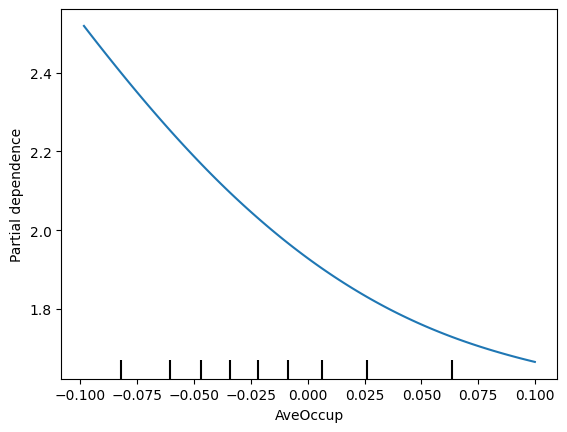

In [36]:
i = 5  # Indice del atributo
mis_features = [(i,)]
display = PartialDependenceDisplay.from_estimator(mlp_regr,
                                                  X_train,
                                                  features=mis_features,
                                                  feature_names=housing_feature_names)

En este caso, el estudio del atributo _AveOccup_, esto es, la media del número de inquilinos en cada casa, determina claramente que si el número medio de inquilino es alto, entonces el precio disminuye.

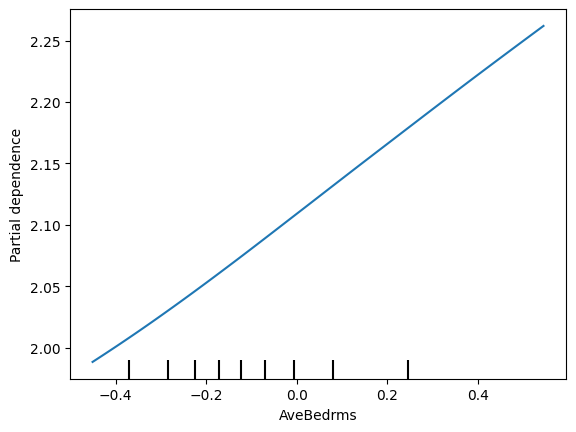

In [37]:
i = 3  # Indice del atributo
mis_features = [(i,)]
display = PartialDependenceDisplay.from_estimator(mlp_regr,
                                                  X_train,
                                                  features=mis_features,
                                                  feature_names=housing_feature_names)

Aquí la tendencia es al revés, al aumentar el número medio de dormitorios, el precio aumenta.

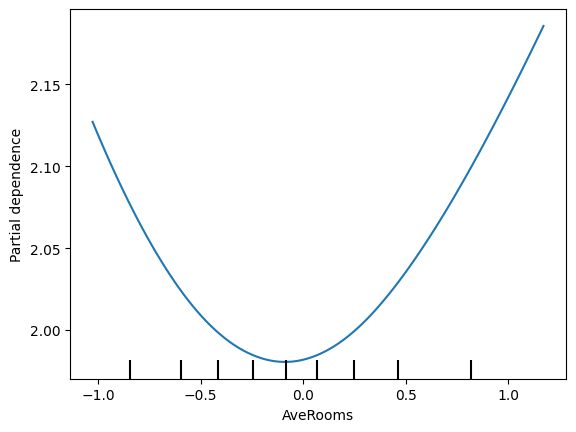

In [38]:
i = 2  # Indice del atributo
mis_features = [(i,)]
display = PartialDependenceDisplay.from_estimator(mlp_regr,
                                                  X_train,
                                                  features=mis_features,
                                                  feature_names=housing_feature_names)

Aquí la gráfica nos indica que el precio de la vivienda está muy influido por el número medio de habitaciones. Si el número de habitaciones es muy pequeño o muy alto, entonces el precio se encarece.

También podemos obtener más de una gráfica para poder comparar

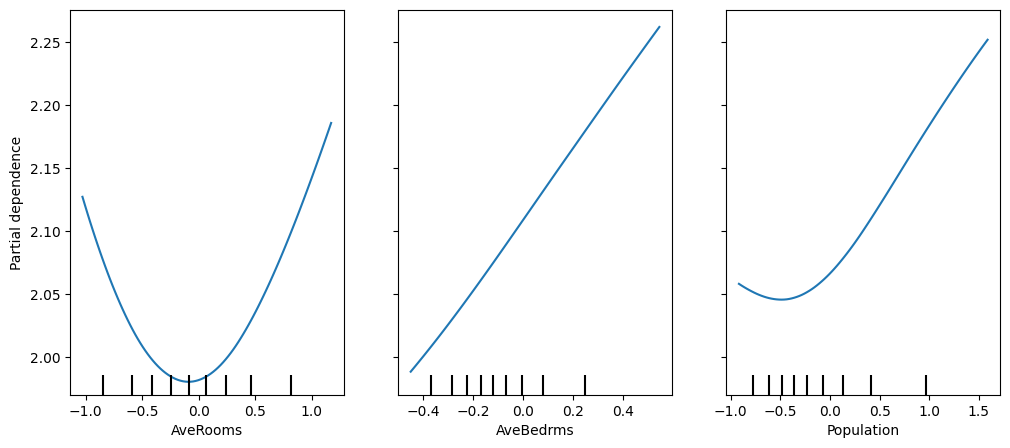

In [39]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,5) # Para el tamaño de la imagen

mis_features = [2,3,4]
display = PartialDependenceDisplay.from_estimator(mlp_regr,
                                                  X_train,
                                                  features=mis_features,
                                                  feature_names=housing_feature_names)

El distinto comportamiento de las variables nos da una idea de la relación que tiene su evolución con la predicción final. También podemos representar la dependencia de manera conjunta mediante un mapa de calor.

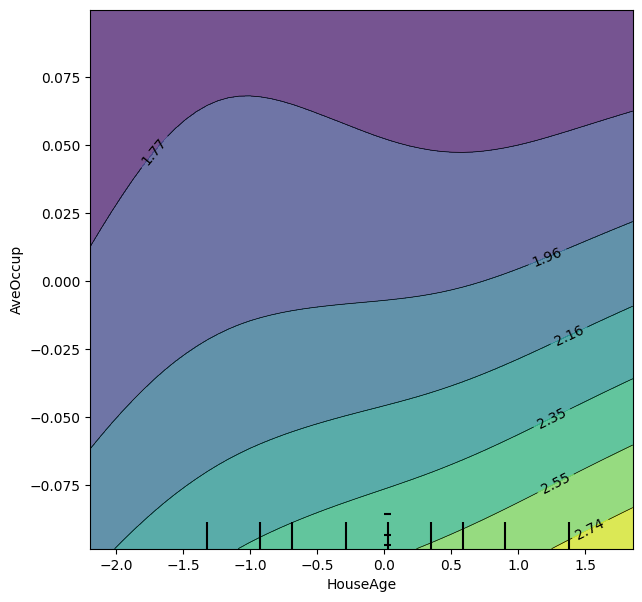

In [40]:
mpl.rcParams['figure.figsize'] = (7,7) # Para el tamaño de la imagen

mis_features = [(1,5)]
display = PartialDependenceDisplay.from_estimator(mlp_regr,
                                                  X_train,
                                                  features=mis_features,
                                                  feature_names=housing_feature_names)

# Individual Conditional Expectation Plots

Vamos a cambiar un poco y en este caso vamos a entrenar un nuevo MLP con tres capas.

In [41]:
mlp_regr_2 = MLPRegressor(hidden_layer_sizes=[30, 20, 10],max_iter=500)
mlp_regr_2.fit(X_train, y_train);

Podemos dibujar su Partial Dependence Plot para un atributo. Obviamente, la gráfica cambia al cambiar el modelo de predicción.

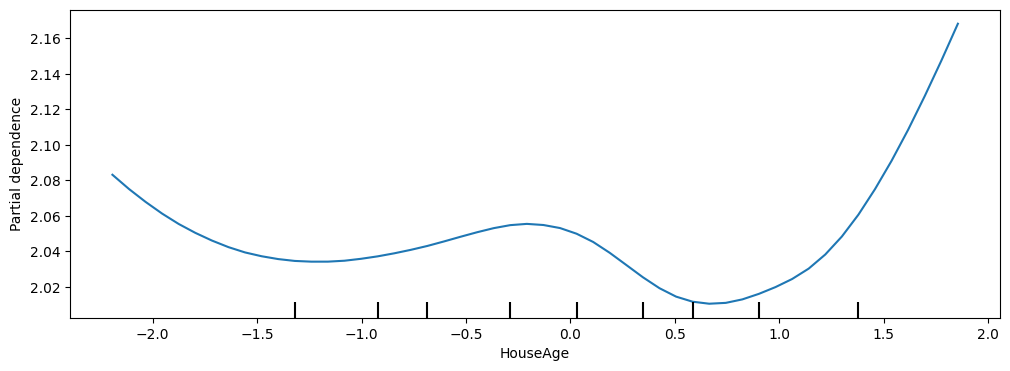

In [42]:
mpl.rcParams['figure.figsize'] = (12,4) # Para el tamaño de la imagen
display = PartialDependenceDisplay.from_estimator(mlp_regr_2,
                                                  X_train,
                                                  features=[(1,)],
                                                  feature_names=housing_feature_names)

Para dibujar los ICEs, usamos la misma función que para los PDP. Sólo tenemos que cambiar el valor del parámetro "kind". Por defecto toma el valor 'average' y dibuja los PDP. Si cambiamos el valor a 'individual' obtenemos los ICEs

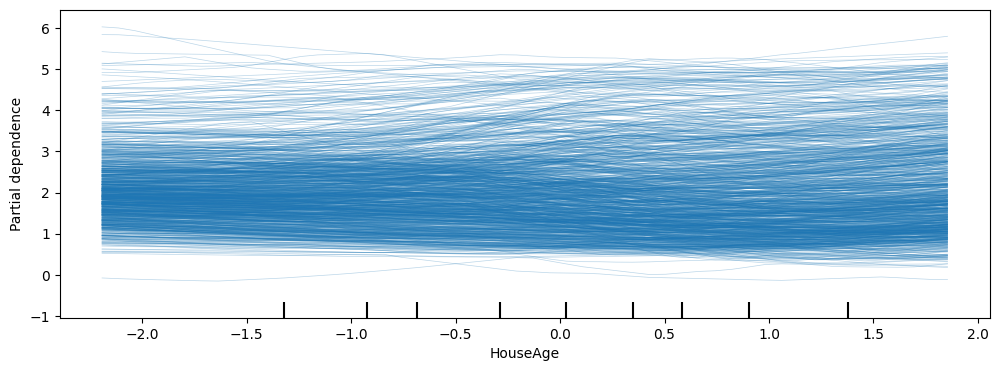

In [43]:
display = PartialDependenceDisplay.from_estimator(mlp_regr_2,
                                                  X_train,
                                                  kind='individual',
                                                  features=[(1,)],
                                                  feature_names=housing_feature_names)


También podemos obtener ambas gráficas en la misma imagen cambiando el valor de 'kind' a 'both'

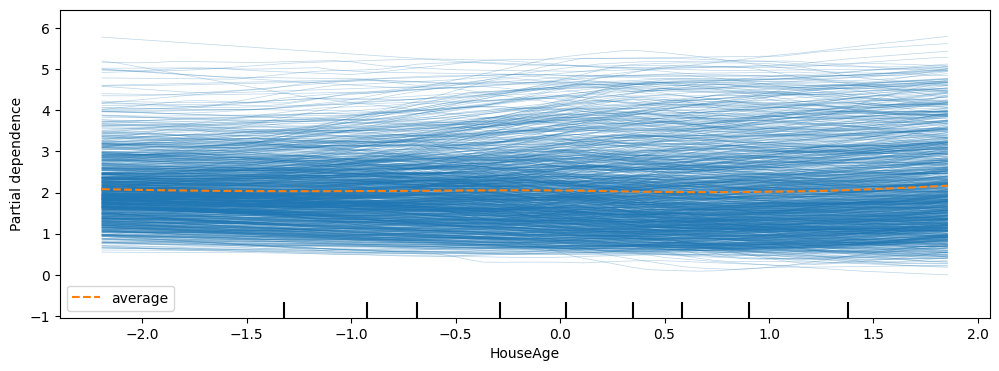

In [44]:
display = PartialDependenceDisplay.from_estimator(mlp_regr_2,
                                                  X_train,
                                                  kind='both',
                                                  features=[(1,)],
                                                  feature_names=housing_feature_names)

Puede ser ilustrativo comparar ambas gráficas para los distintos atributos. Presta atención a la escala en el eje vertical.

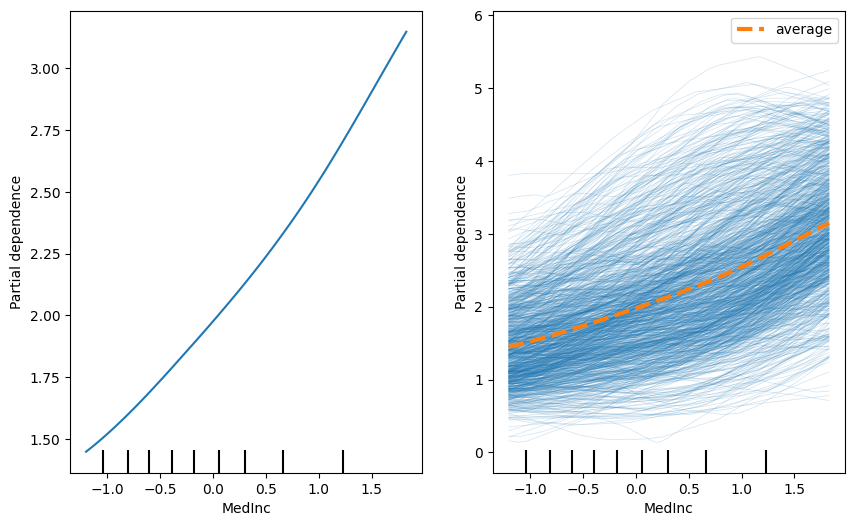

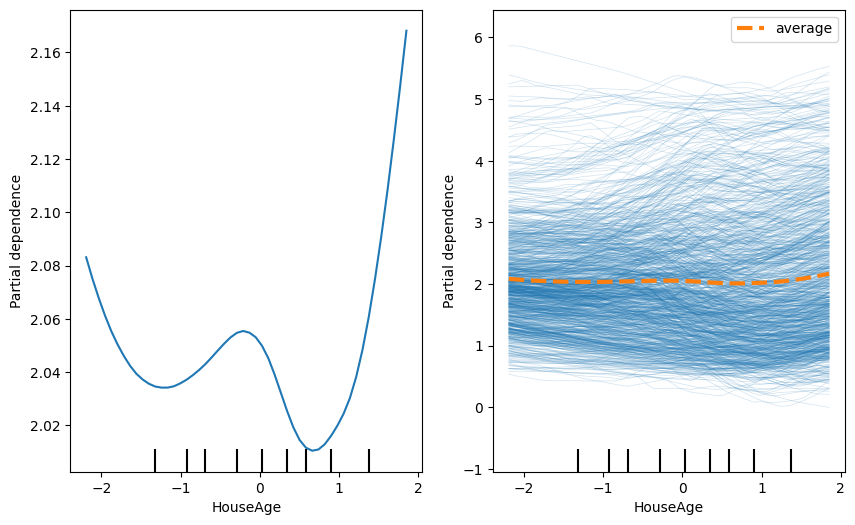

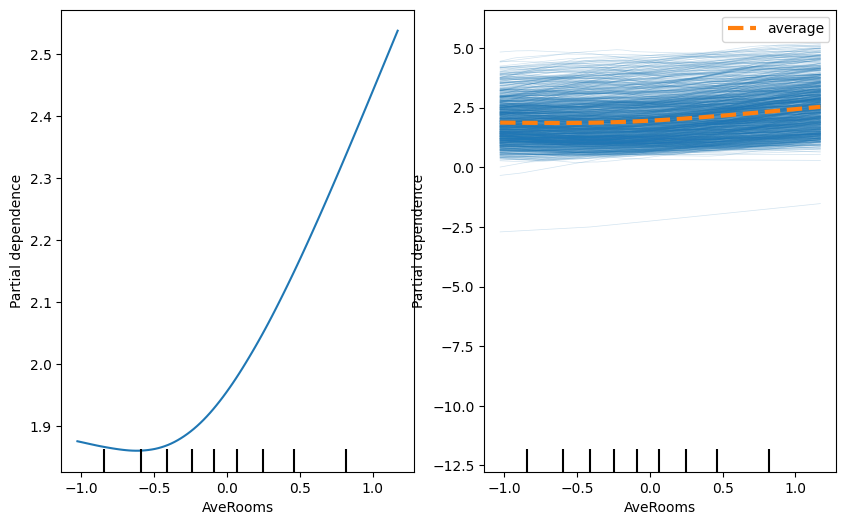

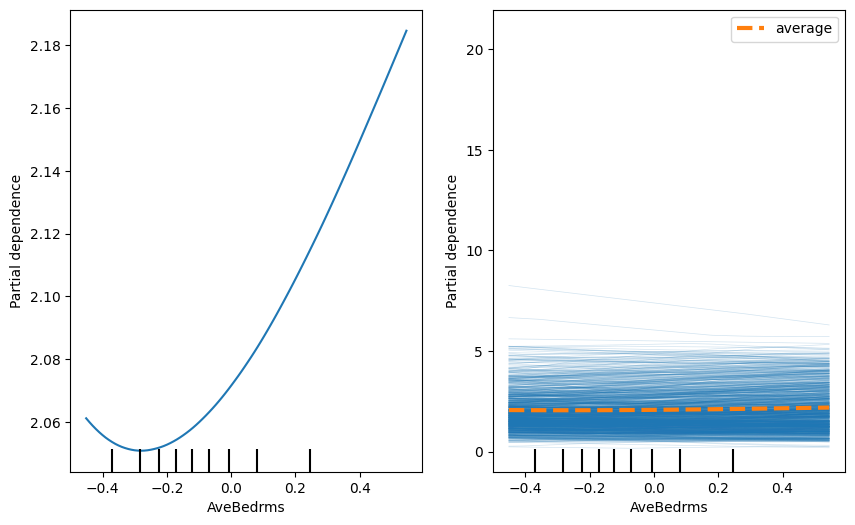

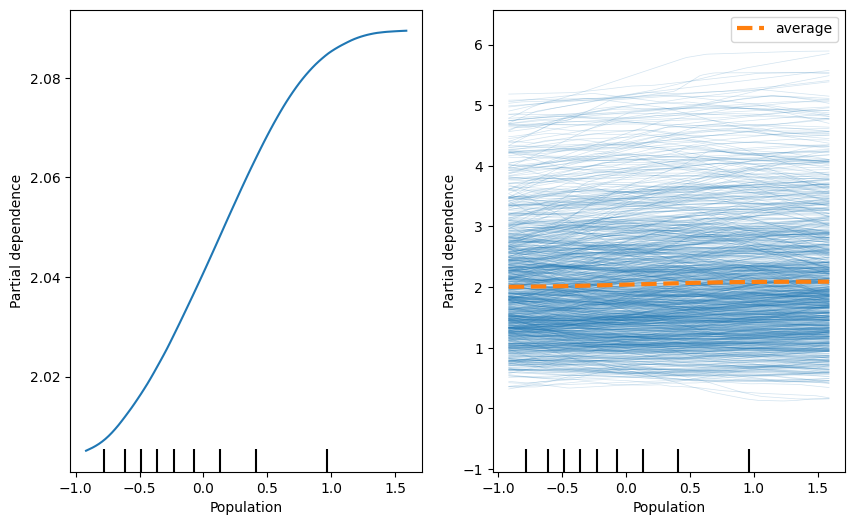

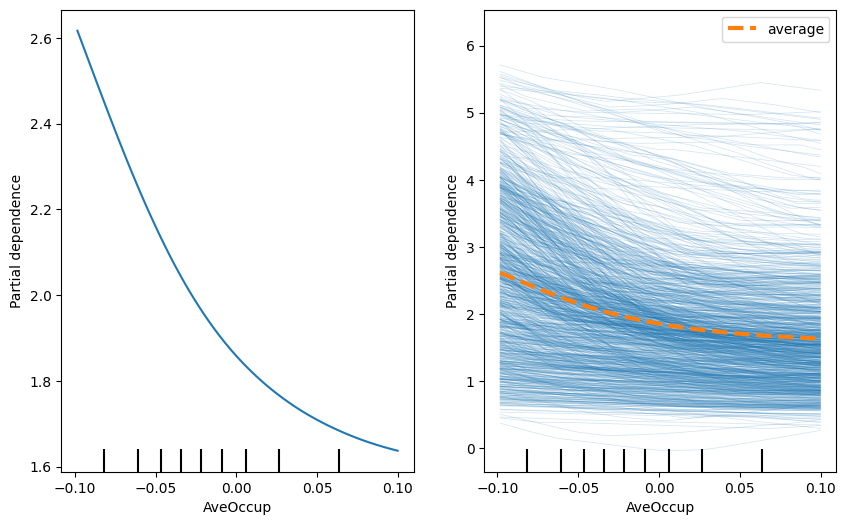

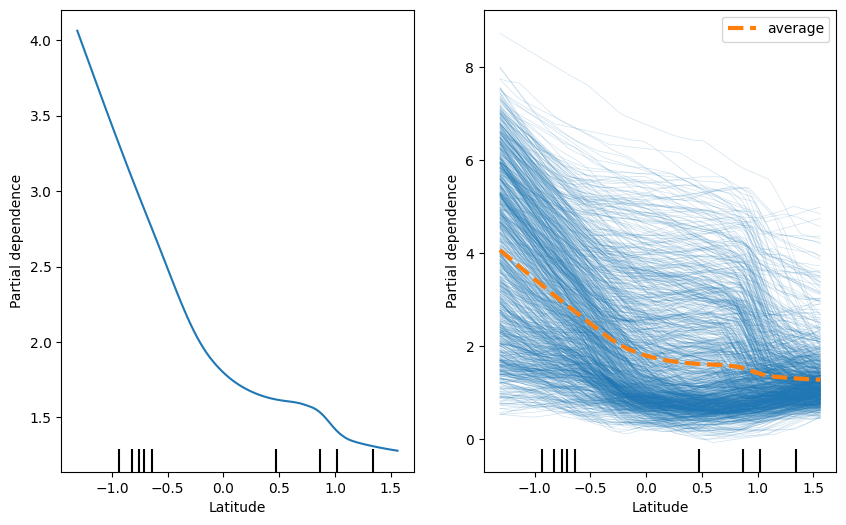

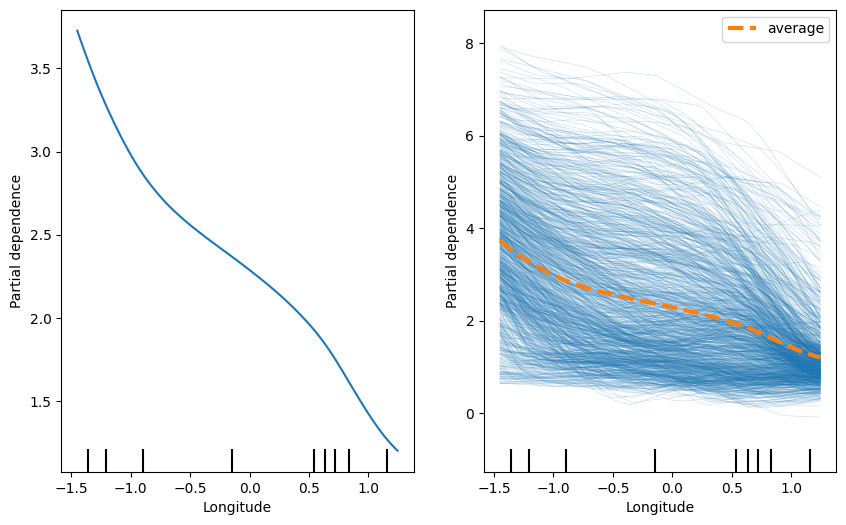

In [45]:
for i in range(len(housing_feature_names)):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
  PartialDependenceDisplay.from_estimator(mlp_regr_2,
                                                  X_train,
                                                  kind='average',
                                                  features=[(i,)],
                                                  ax=ax1,
                                                  feature_names=housing_feature_names)
  PartialDependenceDisplay.from_estimator(mlp_regr_2,
                                                  X_train,
                                                  kind='both',
                                                  features=[(i,)],
                                                  ax=ax2,
                                                  feature_names=housing_feature_names,
                                                  ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
                                                  pd_line_kw={"color": "tab:orange", "linestyle": "--", "linewidth": 3.0})
  plt.show()


# LIME

Instalamos LIME. Más información en https://github.com/marcotcr/lime


In [46]:
!pip -q install lime
import lime
import lime.lime_tabular

# Fijamos la semilla de los valores aleatorios
np.random.seed(123)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


'Titanic' es uno de los conjuntos de datos clásicos de aprendizaje automático utilizados para predecir la supervivencia de pasajeros en el hundimiento del Titanic. Son datos para un problema de clasificación binaria. Aunque este conjunto de datos no es muy complejo, contiene todo tipo de características como categóricas, ordinales, continuas e incluso ciertos identificadores que no son relevantes para la clasificación, lo que lo convierte en un conjunto de datos interesante con el que trabajar. Puede encontrar más detalles sobre el conjunto de datos en: https://data.world/nrippner/titanic-disaster-dataset

In [47]:
titanic = fetch_openml("titanic", version=1, as_frame=True, return_X_y=False)

Vemos que para cada pasajero tenemos varios atributos

In [48]:
titanic.data.columns

Index(['pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare',
       'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

Nos quedamos sólo algunos atributos y eliminamos aquellos que consideramos irrelevantes. Además, le añadimos la columna del atributo "survived" y eliminamos las entradas con valores desconocidos 'NA'.

In [49]:
X_clean = titanic.data.drop(columns=['name', 'cabin', 'boat','body','home.dest','ticket'])
data = pd.concat([X_clean, titanic.target], axis=1)
data.dropna(inplace=True)

Vemos cómo nos ha quedado el dataset y su tamaño

In [50]:
data.head()

pclass     sex      age  sibsp  parch      fare embarked survived
0     1.0  female  29.0000    0.0    0.0  211.3375        S        1
1     1.0    male   0.9167    1.0    2.0  151.5500        S        1
2     1.0  female   2.0000    1.0    2.0  151.5500        S        0
3     1.0    male  30.0000    1.0    2.0  151.5500        S        0
4     1.0  female  25.0000    1.0    2.0  151.5500        S        0

In [51]:
print('Tamaño del dataset:',data.shape)

Tamaño del dataset: (1043, 8)


Cambiamos los valores nominales de 'Sex' a valores numéricos (Female = 0; Male = 1)

In [52]:
data['sex'] = LabelEncoder().fit_transform(data['sex']).astype('int')
data.head()

pclass  sex      age  sibsp  parch      fare embarked survived
0     1.0    0  29.0000    0.0    0.0  211.3375        S        1
1     1.0    1   0.9167    1.0    2.0  151.5500        S        1
2     1.0    0   2.0000    1.0    2.0  151.5500        S        0
3     1.0    1  30.0000    1.0    2.0  151.5500        S        0
4     1.0    0  25.0000    1.0    2.0  151.5500        S        0

Otro atributo no numérico que va a necesitar preprocesamiento es 'embarked'. Vemos los valores de esa columna.

In [53]:
data['embarked'].unique()

['S', 'C', 'Q']
Categories (3, object): ['C', 'Q', 'S']

Traducimos estos valores a indicadores on una columna para cada uno de los tres valores. Por cierto, los valores S, C y Q corresponden al puerto de embarque (C = Cherbourg; Q = Queenstown; S = Southampton)

In [54]:
data = pd.get_dummies(data, columns=['embarked'],dtype='int')

In [55]:
data.head()

pclass  sex      age  sibsp  parch      fare survived  embarked_C  \
0     1.0    0  29.0000    0.0    0.0  211.3375        1           0   
1     1.0    1   0.9167    1.0    2.0  151.5500        1           0   
2     1.0    0   2.0000    1.0    2.0  151.5500        0           0   
3     1.0    1  30.0000    1.0    2.0  151.5500        0           0   
4     1.0    0  25.0000    1.0    2.0  151.5500        0           0   

   embarked_Q  embarked_S  
0           0           1  
1           0           1  
2           0           1  
3           0           1  
4           0           1

Otro de los atributos que vamos a procesar es la clase ala que pertenece el pasajero (primera, segunda o tercera). Igual que antes, creamos una columna para cada valor y tomamos valores 0 o 1.

In [56]:
data['pclass'].unique()

array([1., 2., 3.])

In [57]:
data = pd.get_dummies(data, columns=['pclass'],dtype='int')
data.head()

sex      age  sibsp  parch      fare survived  embarked_C  embarked_Q  \
0    0  29.0000    0.0    0.0  211.3375        1           0           0   
1    1   0.9167    1.0    2.0  151.5500        1           0           0   
2    0   2.0000    1.0    2.0  151.5500        0           0           0   
3    1  30.0000    1.0    2.0  151.5500        0           0           0   
4    0  25.0000    1.0    2.0  151.5500        0           0           0   

   embarked_S  pclass_1.0  pclass_2.0  pclass_3.0  
0           1           1           0           0  
1           1           1           0           0  
2           1           1           0           0  
3           1           1           0           0  
4           1           1           0           0

Por último, separamos los datos en los conjuntos de entrenamiento y prueba, dejando el 20% de los datos para el conjunto de test.

In [58]:
features = data.drop(columns=['survived'])
labels = data['survived'].astype('int')

x_train,x_test,y_train,y_test = train_test_split(features,labels,test_size=0.2, random_state=123)

A continuación tomamos un modelo de aprendizaje automático y lo entrenamos. En este caso tomamos XGBoost, que está basado en árboles. Más información en https://xgboost.readthedocs.io/en/stable/

In [59]:
from xgboost import XGBClassifier
model_titanic = XGBClassifier(n_estimators = 300, random_state = 123)
model_titanic.fit(x_train, y_train);

In [60]:
model_titanic.score(x_test, y_test)

0.7655502392344498

Vemos que no tenemos mucha capacidad de predicción con este modelo. Vamos a definir una función de predicción de la probabilidad que usaremos con LIME. El método predict_proba() devuelve la probabilidad de que una instancia pertenezca a la clase 1.


In [61]:
predict_fn = lambda x: model_titanic.predict_proba(x)

Vamos a usar LIME para tratar de explicar la importancia de los atributos. En primer lugar definimos un objeto 'explainer' de LIME.

In [62]:
explainer = lime.lime_tabular.LimeTabularExplainer(data[features.columns].astype(int).values,
                                                   mode='classification',
                                                   class_names=['Did not Survive', 'Survived'],
                                                   training_labels=data['survived'],
                                                   feature_names=features.columns)

Vamos a usar 'explainer' para explicar una instancia. Guardamos la explicación en la variable 'exp'.

In [63]:
i = 47            # índice de la instancia
mi_num_features = 4   # Número de atributos en la explicación
exp = explainer.explain_instance(data.loc[i,features.columns].astype(int).values, predict_fn, num_features=mi_num_features)

Podemos mostrar la explicación en modo texto ...

In [64]:
exp.as_list()

[('0.00 < sex <= 1.00', -0.5381383104728471),
 ('pclass_3.0 <= 0.00', 0.1662895741481047),
 ('age > 39.00', -0.13249577377835986),
 ('embarked_C <= 0.00', -0.12821884452020932)]

... pero es mucho más descriptivo mostrar la explicación mediante un gráfico

In [65]:
exp.show_in_notebook(show_table=True)

Recordemos los datos de la instancia para la que queremos obtener una explicación.

In [66]:
data.loc[i]

sex                 1
age              42.0
sibsp             0.0
parch             0.0
fare          26.2875
survived            1
embarked_C          0
embarked_Q          0
embarked_S          1
pclass_1.0          1
pclass_2.0          0
pclass_3.0          0
Name: 47, dtype: object

* El gráfico de barras situado más a la izquierda nos muestra las probabilidades de predicción, que pueden tratarse como el nivel de confianza del modelo al realizar la predicción. En este caso, el pasajero tiene muchas más posibilidades de sobrevivir.
* La segunda visualización es probablemente la más importante y proporciona la máxima explicabilidad. Esta visualización nos dice que los 4 atributos más importantes a la hora de decidir han sido:
'sex', 'pclass_3.0','age' y 'fare'. Junto al valor del atributo aparece el intervalo de decisión. Los valores del pasajero para esos atributos están mostrados en el gráfico de la derecha.
* **Interpretación**: Ser un varón (0< sex<=1) influye negativamente en la supervivencia y la edad (age>39) también influye negativamente. No obstante, el pasajero no estaba en tercera clase (pclass_3.0 = 0) y eso era bueno para su supervivencia. Finalmente, tener un billete barato tampoco ayudó.<br>

Podemos representar esta información con un diagrama de barras horizontal.



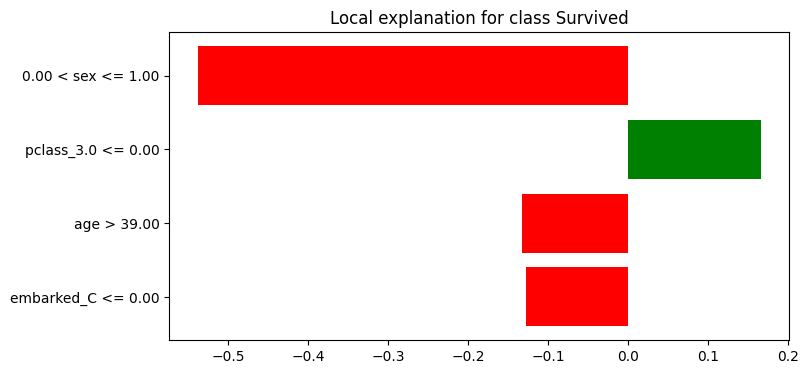

In [67]:
mpl.rcParams['figure.figsize'] = (8,4) # Para el tamaño de la imagen
figure = exp.as_pyplot_figure(label = exp.available_labels()[0])

# SHAP

Por último, vamos a obtener explicaciones mediante SHAP. En primer lugar, instalamos la librería. Puedes obtener más informacion en https://pypi.org/project/shap/

In [68]:
!pip -q install shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 2.9 MB/s eta 0:00:00


Vamos a usar SHAP para obtener explicaciones del mismo modelo que hemos usado para LIME, basado en XGBoost, para el mismo conjunto de entrenamiento. En primer lugar, creamos una instancia de la clase Explainer y calculamos los valores SHAP para las instancias del conjunto de test.

In [69]:
shap_explainer = shap.Explainer(model_titanic, feature_names=features.columns)
shap_values = shap_explainer(x_test)

Comprobamos el el tamaño de la matriz de valores SHAP coincide con el tamaño de la matriz de test

In [70]:
shap_values.shape == x_test.shape

True

El cálculo de los valores SHAP ya está hecho. Parte del éxito de esta librería es que permite representar gráficamente la información con muchos tipos de gráficos, que nos permiten tener una intución de la importancia de los valores.<br>

Por ejemplo, podemos tener la representación _waterfall_ de la primera instancia del conjunto de test

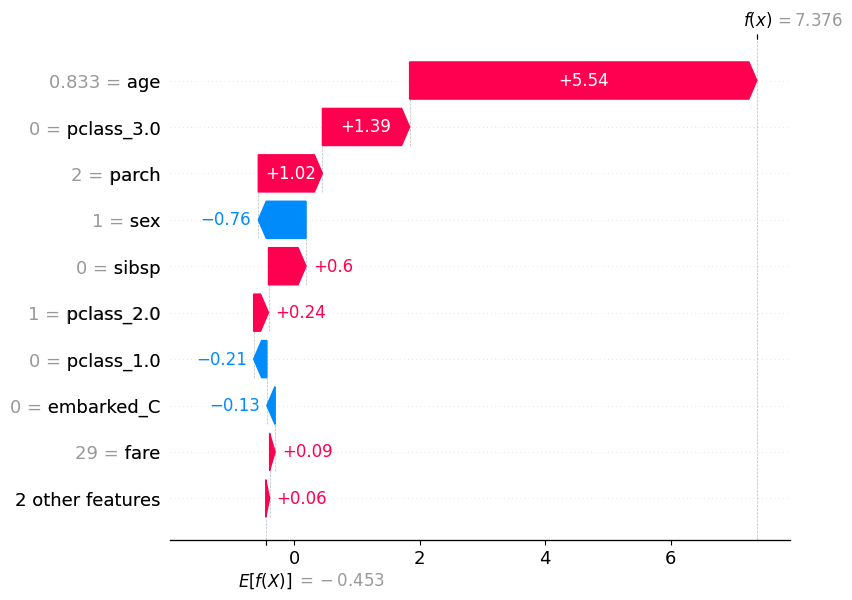

In [71]:
shap.plots.waterfall(shap_values[0])

También podemos tener la misma información, pero representada en un único eje.

In [72]:
shap.initjs()
shap.plots.force(shap_values[0])

La librería también nos permite representar los valores globales. En primer lugar lo vemos en un diagrama de barras horizontales.

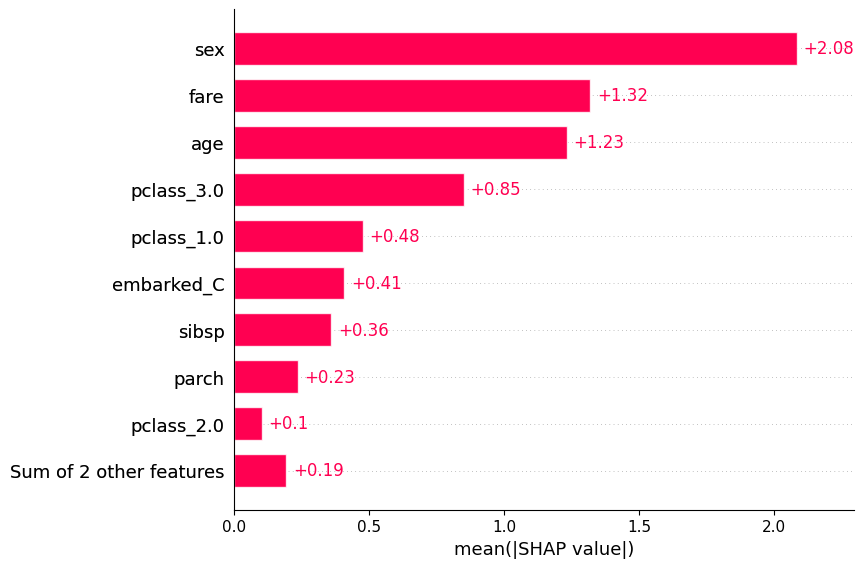

In [73]:
shap.plots.bar(shap_values)

También podemos tener un gráfico interactivo representando todos los vales para todas las instancias. Cambiando la opción del menú en la parte superior obtenemos diversas representaciones. Una opción muy útil es ver atributo a atributo, con la correspondiente elección en el menú.

In [74]:
shap.initjs()
shap.plots.force(shap_values)

Hay muchas posibles respresentaciones. La siguiente es la _beeswarm_ que representa todos los valores SHAP de todas las instancias mezclando un mapa de calor sobre ejes horizontales.

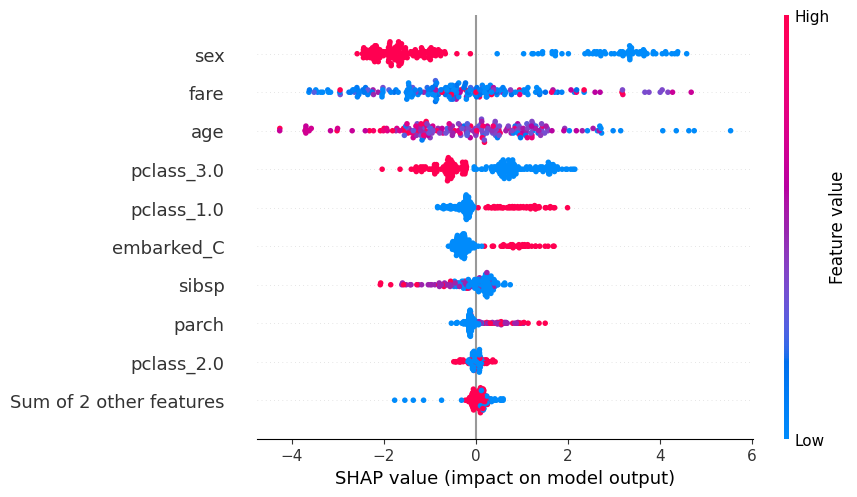

In [75]:
shap.plots.beeswarm(shap_values)

Aunque sin duda, una de las represntaciones más útiles es la _scatter_plot_ que representa los valores de un atributo concreto como nube de puntos.

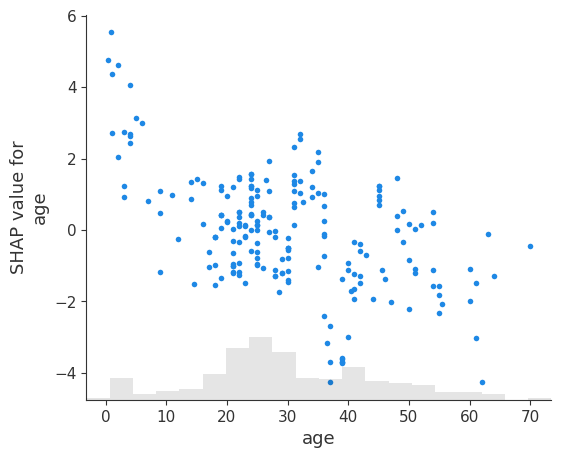

In [76]:
shap.plots.scatter(shap_values[:,"age"])

Hay muchas más representaciones. Más información en https://shap.readthedocs.io/